In [38]:
from pathlib import Path
import pandas as pd
from pandas.errors import EmptyDataError, ParserError
from tqdm import tqdm

BASE = Path("/Users/shrutikmk/Documents/90DAYS/kaggle-stock-ml/data/Data")

In [39]:
def load_stock_data(folder: str) -> pd.DataFrame:
    folder_path = BASE / folder
    files = sorted(folder_path.glob("*.txt"))
    print(f"[INFO] Scanning {folder_path} … found {len(files)} files")

    dfs = []
    bad = []

    for f in tqdm(files, desc=f"Reading {folder}"):
        # quick skip for truly empty files
        if f.stat().st_size == 0:
            bad.append((f.name, "empty (0 bytes)"))
            continue

        try:
            df = pd.read_csv(
                f,
                sep=",",
                engine="c",               # fast; switch to 'python' if needed
                on_bad_lines="skip",      # skip broken lines (pandas >=1.4)
                encoding="utf-8",
            )
            # Some broken files may have no columns even if non-empty
            if df.empty or df.shape[1] == 0:
                bad.append((f.name, "no columns / empty after parse"))
                continue

            df["Ticker"] = f.stem  # filename without extension, e.g. aapl.us
            dfs.append(df)

        except EmptyDataError:
            bad.append((f.name, "EmptyDataError"))
        except ParserError as e:
            bad.append((f.name, f"ParserError: {e}"))
        except UnicodeDecodeError:
            # retry with latin1 if UTF-8 fails
            try:
                df = pd.read_csv(
                    f, sep=",", engine="python", on_bad_lines="skip", encoding="latin1"
                )
                if df.empty or df.shape[1] == 0:
                    bad.append((f.name, "no columns / empty after parse (latin1)"))
                    continue
                df["Ticker"] = f.stem
                dfs.append(df)
            except Exception as e2:
                bad.append((f.name, f"Unicode/parse fail after retry: {e2}"))
        except Exception as e:
            bad.append((f.name, f"Unexpected: {e}"))

    if not dfs:
        raise ValueError(f"No valid dataframes parsed from {folder_path}. "
                         f"First few failures: {bad[:5]}")

    out = pd.concat(dfs, ignore_index=True)

    # ---- light cleanup / typing ----
    # Standard column names for this Kaggle dump
    # Date,Open,High,Low,Close,Volume,OpenInt
    rename_map = {c: c.strip().title() for c in out.columns}
    out.rename(columns=rename_map, inplace=True)

    # Parse date
    if "Date" in out.columns:
        out["Date"] = pd.to_datetime(out["Date"], errors="coerce")

    # Coerce numerics (some files have stray strings)
    for col in ("Open", "High", "Low", "Close", "Volume", "Openint"):
        if col in out.columns:
            out[col] = pd.to_numeric(out[col], errors="coerce")

    # Drop rows with no date or close price
    out = out.dropna(subset=["Date", "Close"])

    # Sort for time-series ops
    out = out.sort_values(["Ticker", "Date"]).reset_index(drop=True)

    print(f"[INFO] Loaded {len(out):,} rows from {folder} "
          f"({len(files)} files; skipped {len(bad)} files)")
    if bad:
        print("[WARN] Examples of skipped files:", bad[:5])
    return out

In [40]:
stocks = load_stock_data("Stocks")
etfs = load_stock_data("ETFs")

[INFO] Scanning /Users/shrutikmk/Documents/90DAYS/kaggle-stock-ml/data/Data/Stocks … found 7195 files


Reading Stocks: 100%|██████████| 7195/7195 [00:15<00:00, 454.10it/s]


[INFO] Loaded 14,887,665 rows from Stocks (7195 files; skipped 32 files)
[WARN] Examples of skipped files: [('accp.us.txt', 'empty (0 bytes)'), ('amrh.us.txt', 'empty (0 bytes)'), ('amrhw.us.txt', 'empty (0 bytes)'), ('asns.us.txt', 'empty (0 bytes)'), ('bbrx.us.txt', 'empty (0 bytes)')]
[INFO] Scanning /Users/shrutikmk/Documents/90DAYS/kaggle-stock-ml/data/Data/ETFs … found 1344 files


Reading ETFs: 100%|██████████| 1344/1344 [00:02<00:00, 493.62it/s]


[INFO] Loaded 2,565,578 rows from ETFs (1344 files; skipped 0 files)


In [41]:
df = pd.concat([stocks, etfs], ignore_index=True)
print(df.shape, df.head())

(17453243, 8)         Date    Open    High     Low   Close    Volume  Openint Ticker
0 1999-11-18  30.713  33.754  27.002  29.702  66277506        0   a.us
1 1999-11-19  28.986  29.027  26.872  27.257  16142920        0   a.us
2 1999-11-22  27.886  29.702  27.044  29.702   6970266        0   a.us
3 1999-11-23  28.688  29.446  27.002  27.002   6332082        0   a.us
4 1999-11-24  27.083  28.309  27.002  27.717   5132147        0   a.us


In [42]:
# --- 0) Imports & plotting defaults -----------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.grid"] = True

OUT_DIR = Path("assets/eda")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [43]:
# --- 1) Basic structure & sanity --------------------------------------------
print("[INFO] df.shape:", df.shape)
display(df.head(3))
display(df.tail(3))
display(df.dtypes)

print("\n[INFO] Nulls per column:")
display(df.isna().sum())

# Keep only reasonable rows (some files contain garbage lines)
# Drop rows with missing essential fields
df = df.dropna(subset=["Date", "Close"]).copy()

# Ensure column names are exactly as expected
expected_cols = {"Date","Open","High","Low","Close","Volume","Openint","Ticker"}
print("\n[INFO] Columns present:", set(df.columns))
missing = expected_cols - set(df.columns)
if missing:
    print("[WARN] Missing expected columns:", missing)


[INFO] df.shape: (17453243, 8)


,Date,Open,High,Low,Close,Volume,Openint,Ticker
0,1999-11-18,30.713,33.754,27.002,29.702,66277506,0,a.us
1,1999-11-19,28.986,29.027,26.872,27.257,16142920,0,a.us
2,1999-11-22,27.886,29.702,27.044,29.702,6970266,0,a.us


,Date,Open,High,Low,Close,Volume,Openint,Ticker
17453240,2017-11-08,30.9600,31.29,30.400,31.2793,48771,0,zsl.us
17453241,2017-11-09,31.4803,31.51,31.205,31.2900,34983,0,zsl.us
17453242,2017-11-10,31.1600,32.06,30.960,31.7000,34123,0,zsl.us


Date       datetime64[ns]
Open              float64
High              float64
Low               float64
Close             float64
Volume              int64
Openint             int64
Ticker             object
dtype: object


[INFO] Nulls per column:


Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
Openint    0
Ticker     0
dtype: int64


[INFO] Columns present: {'Date', 'Volume', 'Low', 'Close', 'Ticker', 'High', 'Open', 'Openint'}


[INFO] Unique tickers: 8,507
[INFO] Date range: 1962-01-02 → 2017-11-10


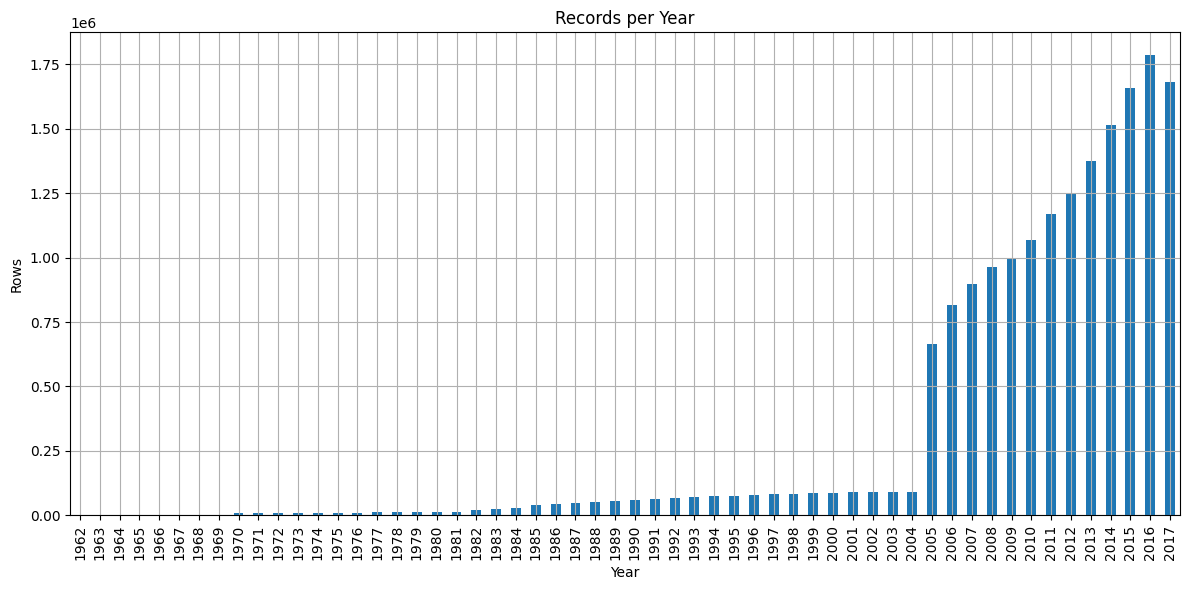

Ticker
ibm.us    14059
ge.us     14058
pg.us     12075
ip.us     12075
aep.us    12075
ko.us     12075
mcd.us    12075
hpq.us    12075
mmm.us    12075
nav.us    12075
dte.us    12075
cat.us    12075
mrk.us    12075
ed.us     12075
ba.us     12074
xom.us    12074
c.us      12074
jpm.us    12074
jnj.us    12074
mo.us     12074
Name: count, dtype: int64

In [44]:
# --- 2) Coverage: tickers and time span -------------------------------------
n_tickers = df["Ticker"].nunique()
date_min  = df["Date"].min()
date_max  = df["Date"].max()
print(f"[INFO] Unique tickers: {n_tickers:,}")
print(f"[INFO] Date range: {date_min.date()} → {date_max.date()}")

# Records per year (quick sanity of coverage)
df["Year"] = df["Date"].dt.year
ax = df["Year"].value_counts().sort_index().plot(kind="bar", title="Records per Year")
ax.set_xlabel("Year"); ax.set_ylabel("Rows")
plt.tight_layout(); plt.savefig(OUT_DIR / "records_per_year.png"); plt.show()

# Counts per ticker (may be huge – show top 20)
ticker_counts = df["Ticker"].value_counts()
display(ticker_counts.head(20))


[INFO] Using sample of 5,000,000 rows for heavy plots


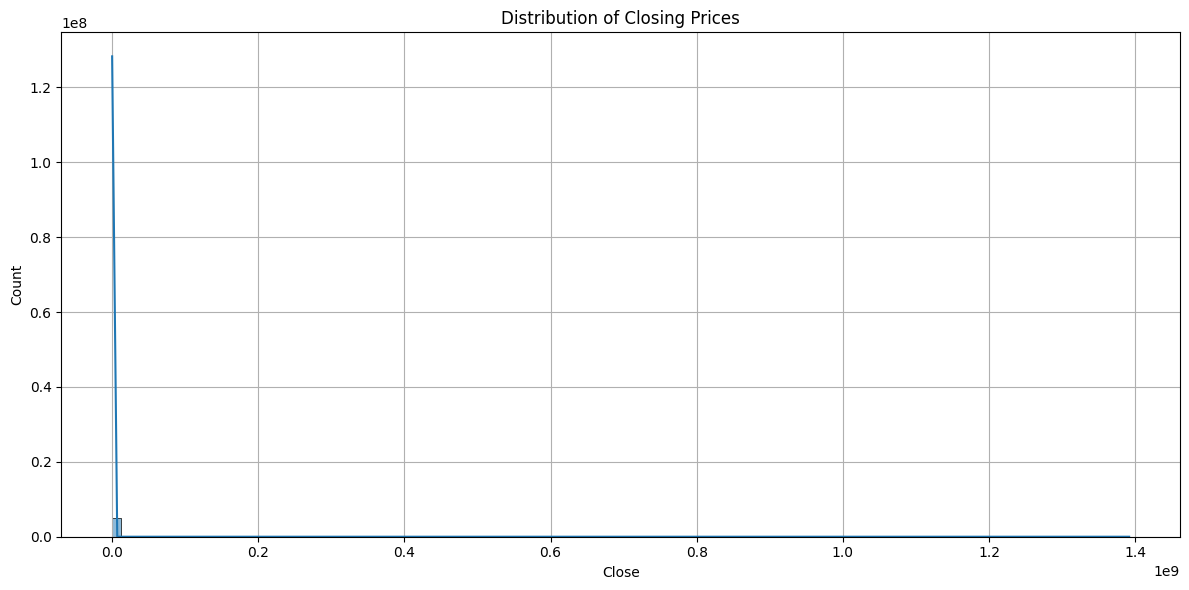

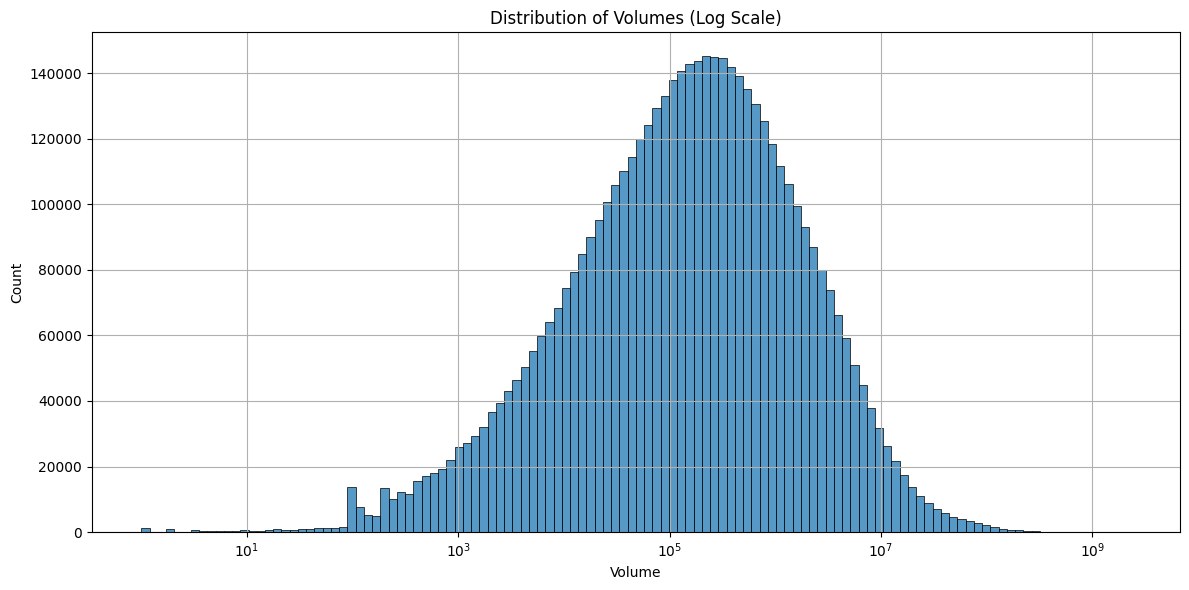

In [45]:
# --- 3) Price/volume distributions (sample if huge) -------------------------
N = len(df)
sample_frac = 1.0 if N <= 5_000_000 else min(5_000_000 / N, 1.0)
df_samp = df.sample(frac=sample_frac, random_state=42) if sample_frac < 1 else df
print(f"[INFO] Using sample of {len(df_samp):,} rows for heavy plots")

fig, ax = plt.subplots()
sns.histplot(df_samp["Close"], bins=120, kde=True, ax=ax)
ax.set_title("Distribution of Closing Prices")
plt.tight_layout(); plt.savefig(OUT_DIR / "dist_close.png"); plt.show()

fig, ax = plt.subplots()
sns.histplot(df_samp["Volume"], bins=120, log_scale=True, ax=ax)
ax.set_title("Distribution of Volumes (Log Scale)")
plt.tight_layout(); plt.savefig(OUT_DIR / "dist_volume.png"); plt.show()

In [46]:
# --- must run BEFORE any sampling/plots that use Return ---
# Ensure types & sort
num_cols = ["Open","High","Low","Close","Volume","Openint"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=["Date","Close"]).sort_values(["Ticker","Date"]).reset_index(drop=True)

# Compute daily returns per ticker
df["Return"] = df.groupby("Ticker", group_keys=False)["Close"].pct_change()

# (Re)create sample AFTER Return exists
N = len(df)
sample_frac = 1.0 if N <= 5_000_000 else min(5_000_000 / N, 1.0)
df_samp = df.sample(frac=sample_frac, random_state=42) if sample_frac < 1 else df


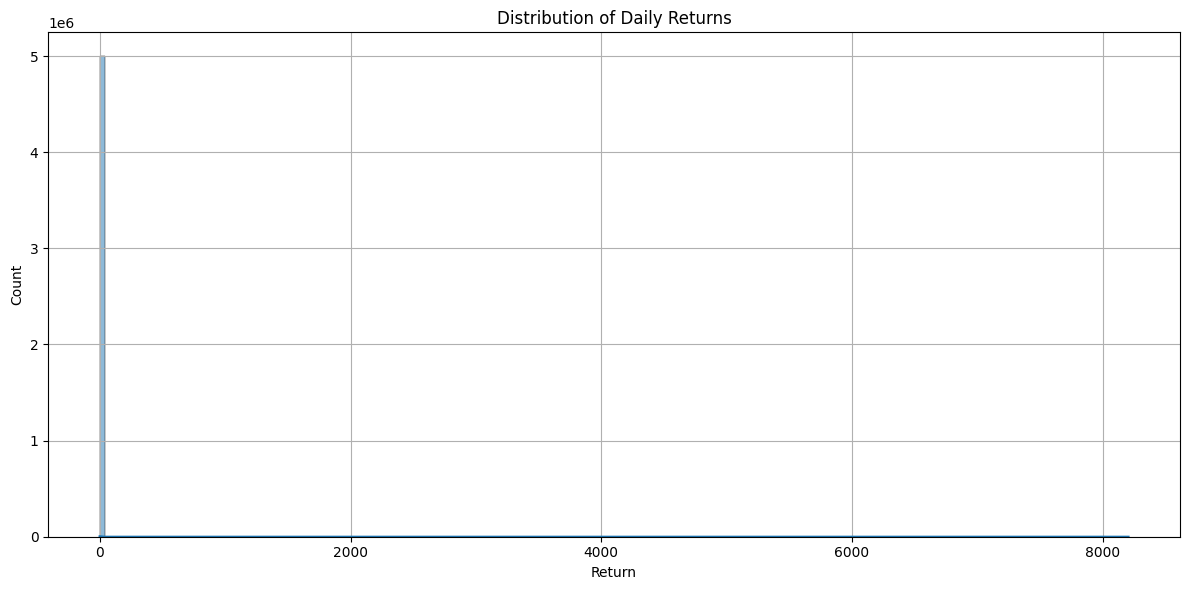

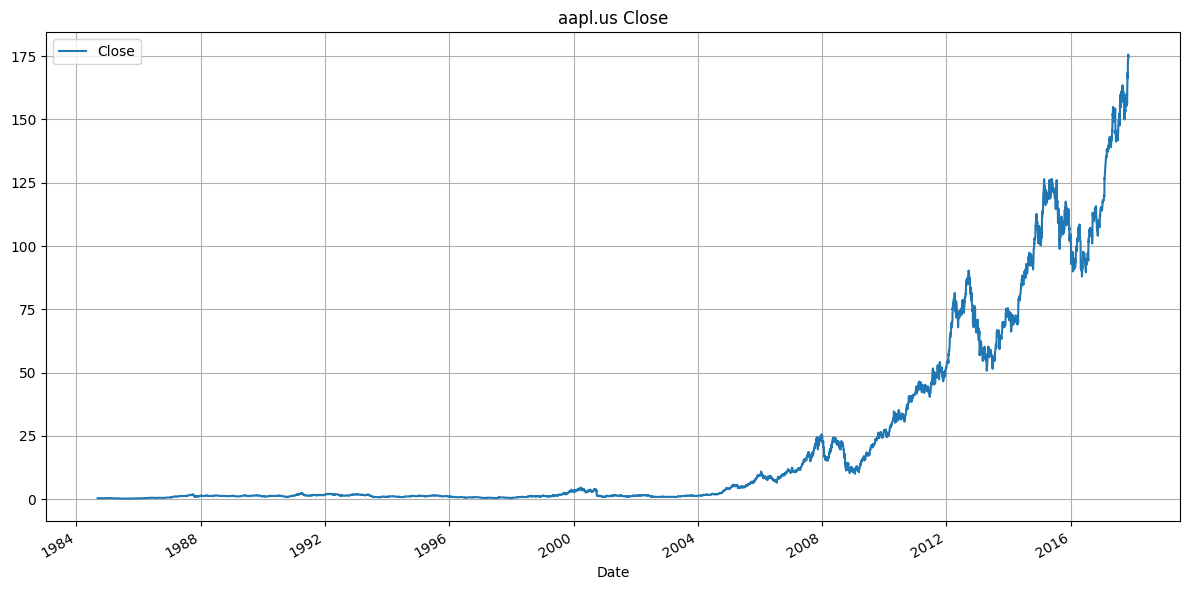

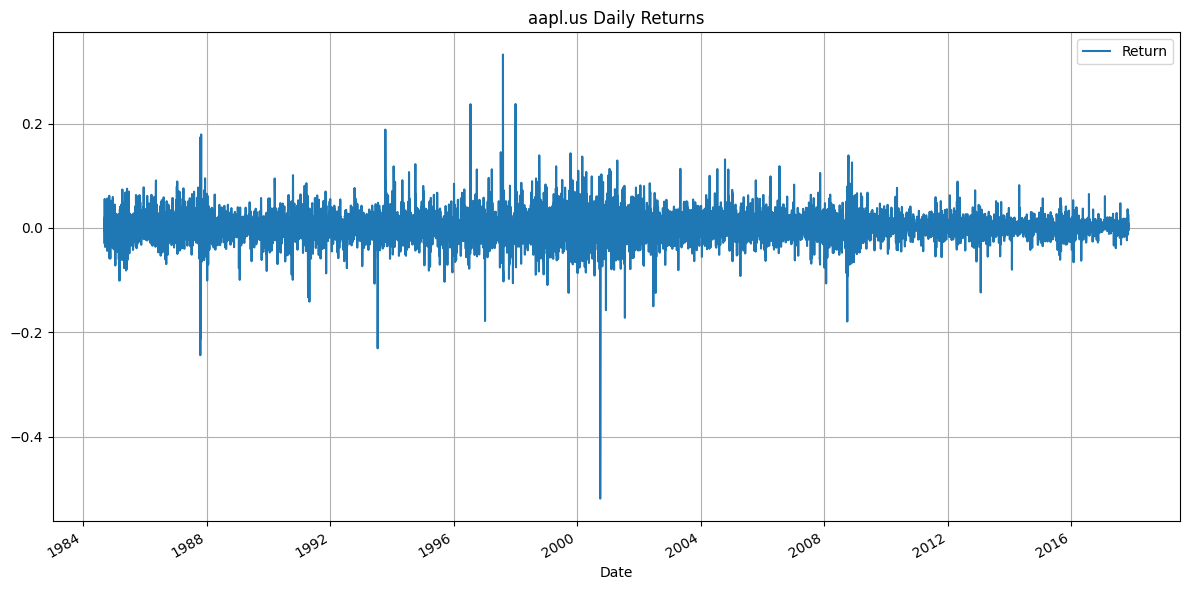

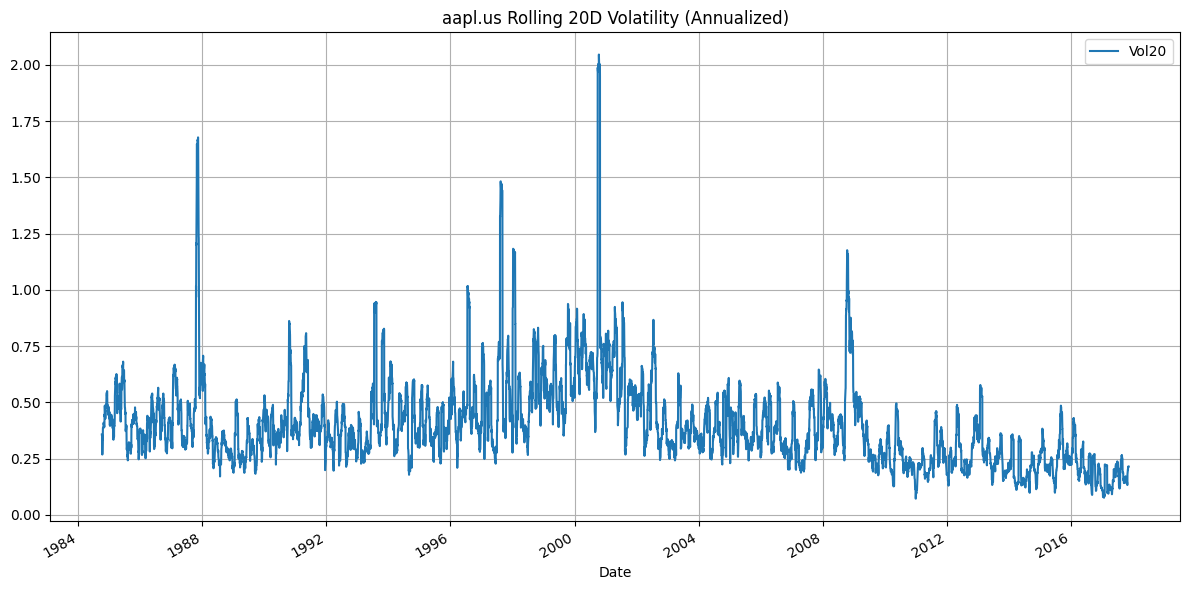

In [47]:
# Ensure sorted for pct_change
df = df.sort_values(["Ticker", "Date"]).reset_index(drop=True)

# Daily returns per ticker
df["Return"] = df.groupby("Ticker", group_keys=False)["Close"].pct_change()

# Plot distribution (use the same sampled df_samp we created earlier if present)
plot_base = df_samp if "df_samp" in locals() else df
ax = sns.histplot(plot_base["Return"].dropna(), bins=200, kde=True)
ax.set_title("Distribution of Daily Returns")
plt.tight_layout(); plt.savefig(OUT_DIR / "dist_returns.png"); plt.show()

# Rolling vol for a focus ticker
focus = "aapl.us"  # change as needed
one = df[df["Ticker"] == focus].copy()
if len(one):
    one["Vol20"] = one["Return"].rolling(20).std() * np.sqrt(252)
    one.plot(x="Date", y="Close", title=f"{focus} Close"); plt.tight_layout(); plt.show()
    one.plot(x="Date", y="Return", title=f"{focus} Daily Returns"); plt.tight_layout(); plt.show()
    one.plot(x="Date", y="Vol20", title=f"{focus} Rolling 20D Volatility (Annualized)"); plt.tight_layout(); plt.show()
else:
    print(f"[WARN] Ticker {focus} not found.")

,Ticker,n_days,med_volume,med_close
7145,spy.us,3201,133631300.0,123.55000
13,aapl.us,8364,74813834.0,1.62825
6305,qqq.us,4701,70838516.0,45.65600
5135,msft.us,7983,70593852.0,20.46900
8372,xlf.us,3201,64183730.0,17.47900
1681,csco.us,6964,62207867.5,15.71700
2280,eem.us,3201,55306020.0,36.57100
4049,intc.us,11556,50109866.5,3.43240
4191,iwm.us,3201,46285254.0,73.01300
6920,siri.us,3201,38109577.0,3.34550


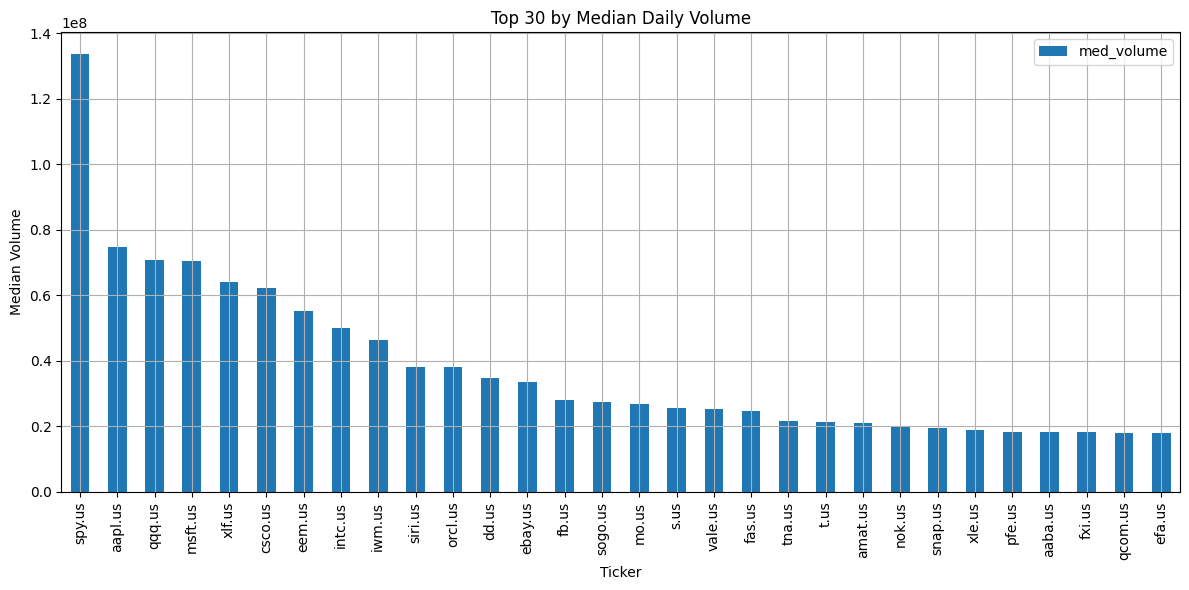

In [48]:
liq = (
    df.groupby("Ticker", as_index=False)
      .agg(
          n_days=("Date", "count"),
          med_volume=("Volume", "median"),
          med_close=("Close", "median"),
      )
      .sort_values("med_volume", ascending=False)
)
display(liq.head(20))
liq.head(200).to_csv(OUT_DIR / "top_liquid_tickers.csv", index=False)

ax = liq.head(30).plot(x="Ticker", y="med_volume", kind="bar",
                       title="Top 30 by Median Daily Volume")
ax.set_ylabel("Median Volume")
plt.tight_layout(); plt.savefig(OUT_DIR / "top30_median_volume.png"); plt.show()


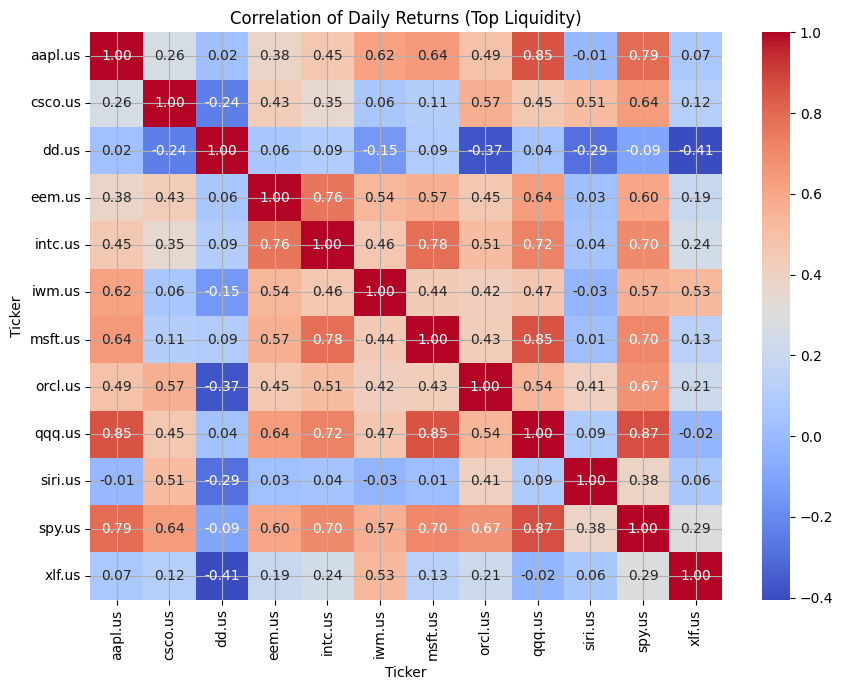

In [49]:
top_symbols = liq.head(12)["Ticker"].tolist()
sub = df[df["Ticker"].isin(top_symbols)].copy()

pivot_ret = sub.pivot(index="Date", columns="Ticker", values="Return").dropna(how="any")
corr = pivot_ret.corr()

plt.figure(figsize=(9,7))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of Daily Returns (Top Liquidity)")
plt.tight_layout(); plt.savefig(OUT_DIR / "corr_top_liquid.png"); plt.show()


,Open,High,Low,Close,Volume,Openint
Date,,,,,,
1984-09-09,0.42388,0.42902,0.41874,0.42388,23220030,0
1984-09-16,0.42388,0.45589,0.41366,0.44566,224316562,0
1984-09-23,0.45718,0.46357,0.42388,0.42902,156830435,0
1984-09-30,0.42902,0.43540,0.39316,0.40081,194131177,0
1984-10-07,0.39956,0.40853,0.39186,0.39699,156037078,0


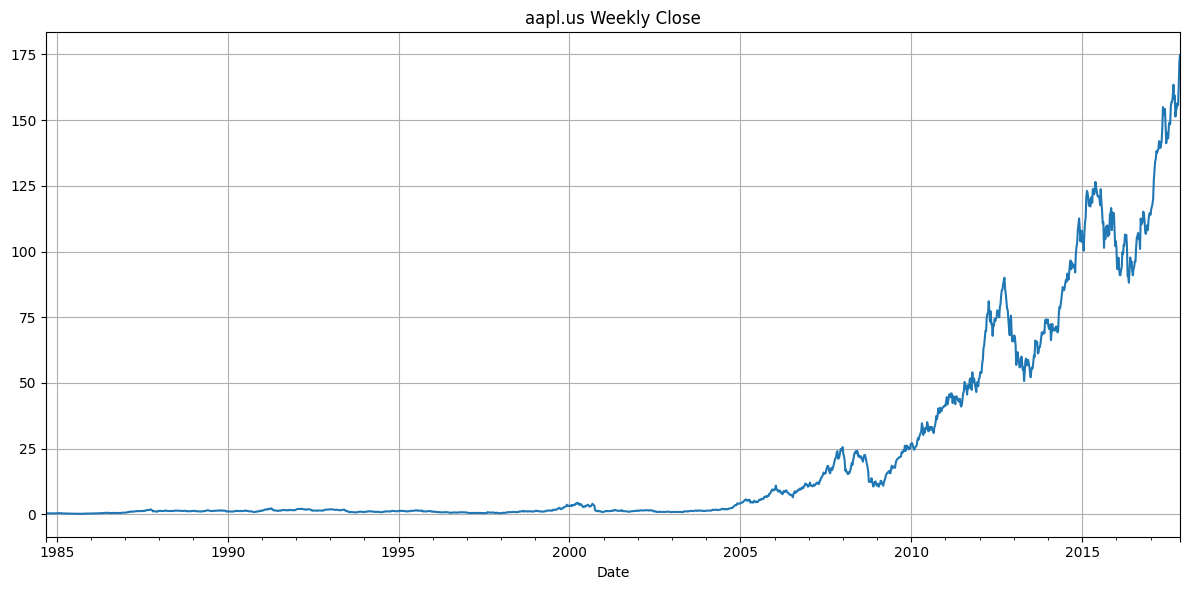

In [50]:
sym = "aapl.us"
one = df[df["Ticker"] == sym].set_index("Date").sort_index()
if len(one):
    wk = one.resample("W").agg(
        Open=("Open","first"),
        High=("High","max"),
        Low=("Low","min"),
        Close=("Close","last"),
        Volume=("Volume","sum"),
        # Open interest is often zero in this dataset; keep if you want:
        Openint=("Openint","last"),
    ).dropna(subset=["Open","High","Low","Close"])
    display(wk.head())
    wk["Close"].plot(title=f"{sym} Weekly Close")
    plt.tight_layout(); plt.savefig(OUT_DIR / f"{sym}_weekly_close.png"); plt.show()
else:
    print(f"[WARN] Ticker {sym} not found for weekly resample.")

In [51]:
spikes = df.loc[df["Return"].abs() > 0.40, ["Date","Ticker","Close","Return"]]
print(f"[INFO] Extreme move rows (>40%): {len(spikes):,}")
display(spikes.head(20))
spikes.to_csv(OUT_DIR / "extreme_moves.csv", index=False)

weird_prices = df[df["Close"] <= 0]
print(f"[INFO] Non-positive close rows: {len(weird_prices):,}")
if len(weird_prices):
    display(weird_prices.head())

[INFO] Extreme move rows (>40%): 6,513


,Date,Ticker,Close,Return
73,2000-03-06,a.us,107.3200,0.472073
20070,2008-02-01,aaba.us,28.3800,0.479666
23061,2016-11-03,aac.us,7.8000,-0.509125
25874,2012-12-14,aamc.us,30.0000,1.000000
25875,2012-12-17,aamc.us,65.0000,1.166667
26818,2016-10-12,aamc.us,49.0000,0.456166
27927,2008-11-21,aame.us,1.1550,0.411808
27932,2008-12-01,aame.us,0.8470,0.419474
27986,2009-03-24,aame.us,0.8566,0.459036
44713,2000-09-29,aapl.us,1.6496,-0.518463


[INFO] Non-positive close rows: 0


In [52]:
summary = (
    df.groupby("Ticker", as_index=False)
      .agg(
          start=("Date","min"),
          end=("Date","max"),
          n_obs=("Date","count"),
          med_close=("Close","median"),
          med_vol=("Volume","median"),
          ret_mean=("Return","mean"),
          ret_std=("Return","std"),
          last_openint=("Openint","last"),
      )
      .sort_values("n_obs", ascending=False)
)
display(summary.head(20))
summary.to_csv(OUT_DIR / "ticker_summary.csv", index=False)

,Ticker,start,end,n_obs,med_close,med_vol,ret_mean,ret_std,last_openint
3849,ibm.us,1962-01-02,2017-11-10,14059,23.02900,4801835.0,0.000350,0.015820,0
3196,ge.us,1962-01-02,2017-11-10,14058,3.88480,15975199.0,0.000381,0.016259,0
5944,pg.us,1970-01-02,2017-11-10,12075,10.85900,5426144.0,0.000445,0.014059,0
1156,cat.us,1970-01-02,2017-11-10,12075,7.63650,3206888.0,0.000530,0.018740,0
4071,ip.us,1970-01-02,2017-11-10,12075,20.76500,1448355.0,0.000453,0.019688,0
5028,mmm.us,1970-01-02,2017-11-10,12075,18.57100,1989692.0,0.000488,0.014338,0
3703,hpq.us,1970-01-02,2017-11-10,12075,3.75110,14291447.0,0.000617,0.023032,0
5104,mrk.us,1970-01-02,2017-11-10,12075,13.99700,6663301.0,0.000511,0.016349,0
5254,nav.us,1970-01-02,2017-11-10,12075,42.50000,355752.0,0.000356,0.031075,0
4842,mcd.us,1970-01-02,2017-11-10,12075,10.81000,4757291.0,0.000675,0.017300,0
